<a href="https://colab.research.google.com/github/RoseJaisil/CNN/blob/main/Implementing_CNN_using_Pytorch_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN

* Import libraries
* Loading the dataset
* Train/ val/ test split
* Dataloader
* Preprocessing
* Constructing CNN until conv layers
* Adding the remaining layers
* Add loss function and optimizer
* Check the number of feature maps at the last conv layer 
* Function for training
* Training and validating for 20 epochs
* Visualize the learning curves
* Evaluate the trained model on the test
* Images labeled with the output classification


# Import necessary libraries

In [41]:
import numpy as np
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load the MNIST dataset

In [3]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train = True, transform=transform, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Train/ val/ test split

In [32]:
mnist_train = Subset(mnist_dataset, torch.arange(10000))
mnist_valid = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

# Dataloader (batch of 64 images for the training and the validation dataset)

In [33]:
batch_size = 64
torch.manual_seed(1)
train_d1 = DataLoader(mnist_train, 
                      batch_size,
                      shuffle=True)
valid_d1 = DataLoader(mnist_valid,
                      batch_size,
                      shuffle=False)

# Constructing CNN until conv layers

In [34]:
model = nn.Sequential()
# First set of convolution layer
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5,
        padding=2
    ))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2)) # pooling size of 2 reduces the dimension by half.

# second set of convolution layer
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=5,
        padding=2
    ))
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))

# Adding the remaining layers

In [35]:
# flatten layer with dim (batch, no. of units)
model.add_module("flatten", nn.Flatten())

# Two fully connected layers
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024,10 ))

# Check the number of feature maps at the last conv layer 
Note: Not a part of the model. This cell is just to check the dimensions as you stack layers.


In [36]:
x = torch.ones([4,1,28,28])
model(x).shape

torch.Size([4, 10])

# Add loss function and optimizer
Note: Don't have to add the softmax activation at the last layer as the crossentropy loss function of the pytorch has it

In [37]:
loss_fn = nn. CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Function for training

Note: model.train()- > To inform that the model is getting trained. This would help to activate the dropout layers and rescale the remaining hidden units for training (Don't have to add dropout layer seperately). Similarly, model.eval() the dropout layer is turned off.


In [38]:
def train(model, num_epochs, train_d1, valid_d1):
  """
  model -> built model
  num_epochs -> epoch is the one complete pass through the training algorithm
  train_d1 -> training data loaded with transforms
  valid_d1 -> validation data loaded with transforms
  """
  # Creating two list of zeros to record the history of losses and accuracies throughout the epoch 
  # Training set
  loss_hist_train = [0] * num_epochs # to record the loss 
  accuracy_hist_train = [0] * num_epochs # to record the accuracy 
  # Validation set
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  # Looping through each epoch
  for epoch in range(num_epochs):
    model.train() # informs the layers that training has begun
    for x_batch, y_batch in train_d1:
      pred = model(x_batch)# Forward pass
      loss = loss_fn(pred, y_batch) # calculate the loss wrt predicition
      loss.backward() # backpropagate the loss -> computes gradients wrt parameters
      optimizer.step() # single optimization
      optimizer.zero_grad() # set the optimized gradients to zero
      loss_hist_train[epoch] += loss.item()*y_batch.size(0) # loss for each batch (summed up)
      is_correct = (
          torch.argmax(pred, dim=1) == y_batch
      ).float()
      accuracy_hist_train[epoch] += is_correct.sum() # how_many are correct

    loss_hist_train[epoch] /= len(train_d1.dataset) # 0 - 1
    accuracy_hist_train[epoch] /= len(train_d1.dataset) # similar

    model.eval()

    with torch.no_grad(): # turn off the gradient calculation while training
      for x_batch, y_batch in valid_d1:
        pred = model(x_batch) # predict for each batch
        loss = loss_fn(pred, y_batch) # calculate the loss
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0) # loss for each epoch (summed up)
        is_correct = (
            torch.argmax(pred, dim=1) == y_batch
        ).float() 
        accuracy_hist_valid[epoch] += is_correct.sum()
      loss_hist_valid[epoch] /= len(valid_d1.dataset)
      accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

    print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy:{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
      

# Training and validating for 20 epochs

In [39]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_d1, valid_d1)


Epoch 1 accuracy: 0.6849 val_accuracy:0.9552
Epoch 2 accuracy: 0.9526 val_accuracy:0.9447
Epoch 3 accuracy: 0.9634 val_accuracy:0.9575
Epoch 4 accuracy: 0.9599 val_accuracy:0.9646
Epoch 5 accuracy: 0.9657 val_accuracy:0.9626
Epoch 6 accuracy: 0.9698 val_accuracy:0.9472
Epoch 7 accuracy: 0.9596 val_accuracy:0.9656
Epoch 8 accuracy: 0.9654 val_accuracy:0.9649
Epoch 9 accuracy: 0.9644 val_accuracy:0.9612
Epoch 10 accuracy: 0.9732 val_accuracy:0.9676
Epoch 11 accuracy: 0.9747 val_accuracy:0.9629
Epoch 12 accuracy: 0.9730 val_accuracy:0.9701
Epoch 13 accuracy: 0.9708 val_accuracy:0.9647
Epoch 14 accuracy: 0.9725 val_accuracy:0.9661
Epoch 15 accuracy: 0.9721 val_accuracy:0.9685
Epoch 16 accuracy: 0.9760 val_accuracy:0.9714
Epoch 17 accuracy: 0.9769 val_accuracy:0.9701
Epoch 18 accuracy: 0.9728 val_accuracy:0.9666
Epoch 19 accuracy: 0.9717 val_accuracy:0.9639
Epoch 20 accuracy: 0.9732 val_accuracy:0.9667


# Visualize the learning curves

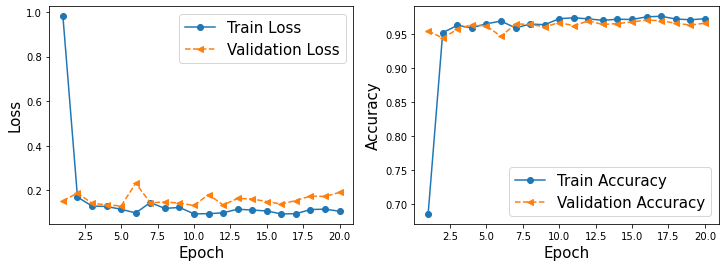

In [42]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], "-o", label='Train Loss')
ax.plot(x_arr, hist[1], "--<", label='Validation Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label='Train Accuracy')
ax.plot(x_arr, hist[3], '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# Evaluate the trained model on the test

In [43]:
pred = model(mnist_test.data.unsqueeze(1)/ 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test.targets
).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9667


# Images labeled with the output classification

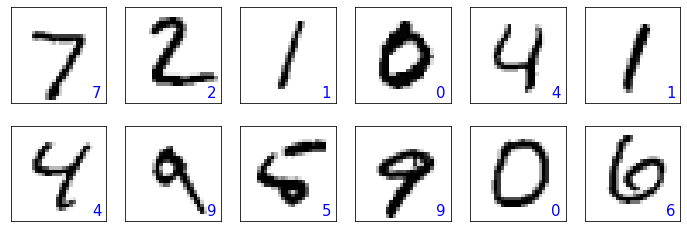

In [47]:
from prompt_toolkit.layout import HorizontalAlign
fig = plt.figure(figsize=(12,4))
for i in range(12):
  ax = fig.add_subplot(2,6,i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test[i][0][0 ,:, :]
  pred = model(img.unsqueeze(0).unsqueeze(1))
  y_pred = torch.argmax(pred)
  ax.imshow(img, cmap = 'gray_r')
  ax.text(0.9, 0.1, y_pred.item(),
          size=15, color='blue',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)
plt.show()